## Anomaly Detection

In [41]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

Reading data from https://github.com/numenta/NAB/tree/master/data. The data is about the number of tweets by Amazon every 5 minutes.

In [42]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv')
data.shape

(15831, 2)

Text(0.5, 1.0, 'Plot the Original data')

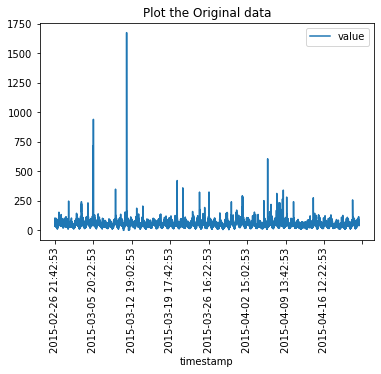

In [43]:
data.set_index('timestamp').plot()
plt.xticks(rotation='vertical')
plt.title("Plot the Original data")

Splitting the data into test and validation. We attempt to predict the next 5 values based on the previous 144 values (half day).

In [44]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):], y[:int(len(y)*0.9)], y[int(len(y)*0.9):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14247, 1), (14247, 1), (1583, 1), (1583, 1))

In [45]:
n_timesteps = 144
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
k=-5
batch_size=128
epochs=50


In [46]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples+1)]
X_train_list = X_train_list[:k]
X_train = np.concatenate(X_train_list, axis=0)
y_train_list = [np.expand_dims(y_train[i:i+5, :], axis=0) for i in range(n_timesteps, n_samples -5 + 1)]
y_train = np.concatenate(y_train_list, axis=0)
X_train = X_train[:-1, :, :]
y_train = y_train[1:, :, :]
# y_train = y_train[n_timesteps-1:, :]


X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val_list = X_val_list[:k]
X_val = np.concatenate(X_val_list, axis=0)
# y_val = y_val[n_timesteps-1:, :]
y_val_list = [np.expand_dims(y_val[i:i+5, :], axis=0) for i in range(n_timesteps, n_val_samples- 5 + 1)]
y_val = np.concatenate(y_val_list, axis=0)
X_val = X_val[:-1, :, :]
y_val = y_val[1:, :, :]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(14098, 144, 1) (14098, 5, 1) (1434, 144, 1) (1434, 5, 1)


Building models with dense layers and LSTM. The output is shown for dense layers. We have only implemented this project using LSTM whose layers are also shown below (commented). For LSTM the input should be 3 dimension and for dense it should be 2 dimensions.

In [47]:

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps,))
    
    # x = LSTM(50, return_sequences=True)(i)
    x = Dense(200, kernel_initializer='he_normal')(i)
    x = Dropout(0.4)(x)
    
    # x = LSTM(50)(x)
    x = Dense(200, kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)

    # x = LSTM(50)(x)
    # x = Dense(200, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    # x = Dense(200, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    x = Dense(5, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [48]:
model = Autoencoder(n_timesteps, 5)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               29000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1005      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                

In [49]:
# model = Autoencoder(n_timesteps, 5)
# model.summary()
history = model.fit(x=X_train.squeeze(), y=y_train.squeeze(), batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
111/111 [==============================] - 1s 5ms/step - loss: 77.4528 - val_loss: 13.5267
Epoch 2/50
111/111 [==============================] - 0s 4ms/step - loss: 20.1028 - val_loss: 14.8261
Epoch 3/50
111/111 [==============================] - 0s 4ms/step - loss: 19.2316 - val_loss: 15.3102
Epoch 4/50
111/111 [==============================] - 0s 4ms/step - loss: 19.3382 - val_loss: 22.0096
Epoch 5/50
111/111 [==============================] - 0s 4ms/step - loss: 19.0044 - val_loss: 11.4444
Epoch 6/50
111/111 [==============================] - 0s 4ms/step - loss: 19.3647 - val_loss: 11.9096
Epoch 7/50
111/111 [==============================] - 0s 4ms/step - loss: 20.9217 - val_loss: 15.9128
Epoch 8/50
111/111 [==============================] - 0s 4ms/step - loss: 20.8974 - val_loss: 26.1692
Epoch 9/50
111/111 [==============================] - 0s 4ms/step - loss: 20.8245 - val_loss: 13.4350
Epoch 10/50
111/111 [==============================] - 0s 4ms/step - loss: 20.7538

In [50]:
y_train_pred = model.predict(X_train)

In [51]:
y_train_pred.shape

(14098, 5)

In [54]:
from sklearn.metrics import mean_absolute_error
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]


Text(0.5, 1.0, 'Distribution of Errors')

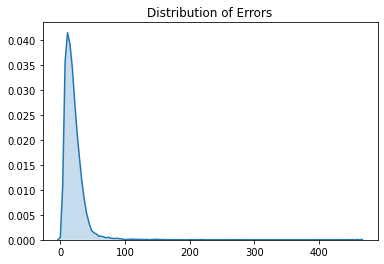

In [55]:
import seaborn as sb
sb.kdeplot(errors, shade=True)
plt.title("Distribution of Errors")

Since we have the list of errors, we plot to them to see how they are distributed.

If the errors for each value of the data set were normally distributed, we can consider all values away that are beyond 1 standard deviation from the mean as anomaly. Hence, we are now fitting this data to a normal distribution.

In [56]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(20.312500732715186, 17.590936989901834)

We get the mean and standard deviation here. We can consider all the values that lie around 1 standard deviation away from the mean. Any value beyond this can be considered an anomaly. We can consider different ranges of error beyond which a value can be anomaly. We have chosen a range of 1 standard deviation from the mean to consider a value normal.

In [57]:
def is_anomaly(error, mean, std, threshold):
    difference = np.abs(error - mean)
    value = difference / std
    if value < threshold:
        return 0
    else:
        return 1

In [58]:
y_val_pred = model.predict(X_val[:, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results = [is_anomaly(x, dist.mean(), dist.std(), 1) for x in val_errors]
print(results)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [59]:
# MSE
from sklearn.metrics import mean_squared_error
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
mse = [mean_squared_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results_mse = [is_anomaly(x, mean(mse), stdev(mse), 1) for x in mse]
print(results_mse)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [60]:
# R2 Score
from sklearn.metrics import r2_score
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
r2 = [r2_score(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results_r2 = [is_anomaly(x, mean(r2), stdev(r2), 1) for x in r2]
print(results_r2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [61]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)


result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]


[0.6199, 0.6266, 0.6498, 0.6853, 0.7496, 0.762, 0.7089, 0.7657, 0.7073, 0.7407, 0.6638, 0.621, 0.5944, 0.5902, 0.5547, 0.5301, 0.5499, 0.5475, 0.6481, 0.6916, 0.7052, 0.6229, 0.6192, 0.6229, 0.5453, 0.6526, 0.6688, 0.6471, 0.5285, 0.6251, 0.6523, 0.7495, 0.7802, 0.7437, 0.7222, 0.7143, 0.7832, 0.8005, 0.8281, 0.8426, 0.8612, 0.8086, 0.7225, 0.6942, 0.5373, 0.5899, 0.7062, 0.6934, 0.6773, 0.6874, 0.6736, 0.5786, 0.6264, 0.6717, 0.683, 0.629, 0.563, 0.5404, 0.5218, 0.568, 0.6201, 0.6303, 0.6546, 0.7417, 0.6377, 0.5923, 0.5226, 0.5097, 0.5163, 0.5343, 0.5145, 0.592, 0.5639, 0.5943, 0.6664, 0.7101, 0.7052, 0.7361, 0.8164, 0.8262, 0.789, 0.8003, 0.8331, 0.761, 0.8108, 0.8263, 0.7741, 0.7415, 0.7263, 0.7716, 0.8041, 0.791, 0.7765, 0.7955, 0.7538, 0.7425, 0.7544, 0.7539, 0.7506, 0.792, 0.8135, 0.8135, 0.7651, 0.8245, 0.8223, 0.8011, 0.7753, 0.7528, 0.7227, 0.7107, 0.6622, 0.6992, 0.6952, 0.7618, 0.8114, 0.7895, 0.8227, 0.7926, 0.8244, 0.744, 0.7431, 0.6918, 0.7433, 0.6693, 0.6547, 0.6517, 0.6

In [62]:
f = []
for i in range(len(y_val)):
  f.append(y_val[i][0])


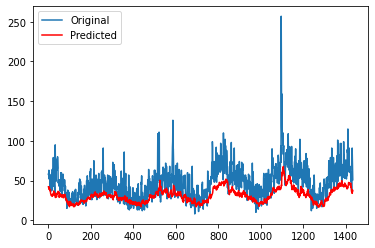

In [63]:
import matplotlib.pyplot as plt

plt.plot(y_val[:,0], label="Original")
plt.plot(y_val_pred[:,0],color="r", label="Predicted")
plt.legend()

We could also come up with a continuous scoring system using the cumulative density function.

The higher the number, the more likely the sample is to be an anomaly.

In [64]:
# For MAE plot
plot_x=[]
plot_y=[]
for i in range(len(results)): 
  if results[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

[array([63]), array([77]), array([23]), array([18]), array([20]), array([21]), array([20]), array([32]), array([64]), array([109]), array([95]), array([71]), array([51]), array([58]), array([98]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([26]), array([55]), array([73]), array([66]), array([69]), array([99]), array([97]), array([90]), array([90]), array([102]), array([58]), array([59]), array([86]), array([90]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([106]), array([159]), array([111]), array([110]), array([83]), array([88]), array([105]), array([109]), array([65]), array([60]), array([53]), array([89]), array([102]), array([97]), array([83]), array([56]), array([89]), array([85]), array([85]), array([115])]


Text(0.5, 1.0, 'MAE Error Metric')

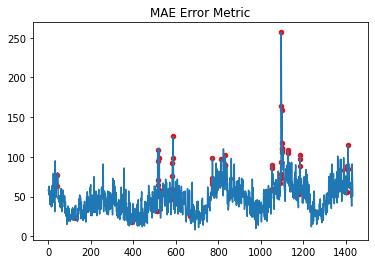

In [65]:
plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)
plt.title("MAE Error Metric")


In [66]:
# For MSE plot
plot_x=[]
plot_y=[]
for i in range(len(results_mse)): 
  if results_mse[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

[array([63]), array([77]), array([23]), array([18]), array([20]), array([21]), array([20]), array([32]), array([64]), array([109]), array([95]), array([71]), array([51]), array([58]), array([98]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([26]), array([55]), array([73]), array([66]), array([69]), array([99]), array([97]), array([90]), array([90]), array([102]), array([58]), array([59]), array([86]), array([90]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([106]), array([159]), array([111]), array([110]), array([83]), array([88]), array([105]), array([109]), array([65]), array([60]), array([53]), array([89]), array([102]), array([97]), array([83]), array([56]), array([89]), array([85]), array([85]), array([115])]


Text(0.5, 1.0, 'MSE Error Metric')

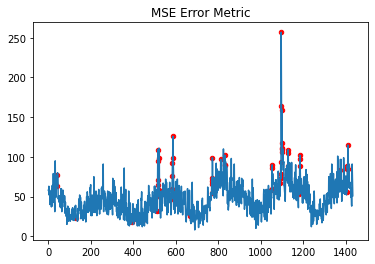

In [67]:
plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)
plt.title("MSE Error Metric")

The red spots are anomalies in the data set and the blue plot is the original data

[array([63]), array([77]), array([23]), array([18]), array([20]), array([21]), array([20]), array([32]), array([64]), array([109]), array([95]), array([71]), array([51]), array([58]), array([98]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([26]), array([55]), array([73]), array([66]), array([69]), array([99]), array([97]), array([90]), array([90]), array([102]), array([58]), array([59]), array([86]), array([90]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([106]), array([159]), array([111]), array([110]), array([83]), array([88]), array([105]), array([109]), array([65]), array([60]), array([53]), array([89]), array([102]), array([97]), array([83]), array([56]), array([89]), array([85]), array([85]), array([115])]


Text(0.5, 1.0, 'R2 Score Metric')

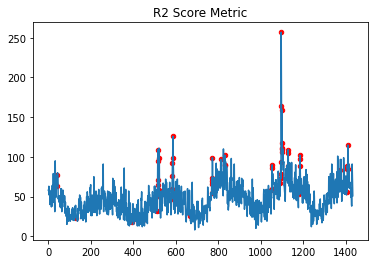

In [68]:
# For R2 plot
plot_x=[]
plot_y=[]
for i in range(len(results_r2)): 
  if results_r2[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r", s=20)
plt.title("R2 Score Metric")

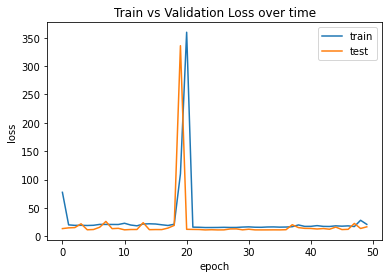

In [69]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='best')